In [21]:
#This is the anomaly index that we came up with
#Load necessary modules
import os
#Some hacks to get around a Basemap issue
os.environ["PYTHONWARNINGS"]="ignore::yaml.YAMLLoadWarning"
import glob
import numpy as np
import xarray as xa
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import nc_time_axis
import cftime
import scipy
import math

In [22]:
#We need the blob data, anom data, and the original extent
model_name="CMCC-CESM"
calendar="noleap"
if model_name=="HadCM3" or model_name=="HadGEM2-CC":
    calendar="360_day"
data_dir="/global/cscratch1/sd/marielp/{:}".format(model_name)

#Open up the total field
data_orig = sorted(glob.glob("{:}/zg_day*.nc".format(data_dir)))
dorig = xa.open_mfdataset(data_orig,use_cftime=True)
if (calendar!="360_day"):
    dorig = dorig.sel(time=~((dorig.time.dt.month==2) & (dorig.time.dt.day == 29)))
#Open up the anomalies
data_dev = sorted(glob.glob("{:}/DEVS/TREND/zg_day*devs.nc".format(data_dir)))
ddev = xa.open_mfdataset(data_dev,use_cftime=True)
#Open up the blobs
data_blob=  sorted(glob.glob("{:}/BLOBS_NOREGIONAL/*blobs_noregional.nc".format(data_dir)))
dblob = xa.open_mfdataset(data_blob,use_cftime=True)
dblob=dblob.sortby(dblob.time)

In [23]:
var_orig = dorig['zg'].sel(plev=50000)
var_dev=ddev['ADZ']
var_blob=dblob['Z_BLOB']

In [24]:
#Issue: If it's a standard calendar, it's encoded as Gregorian (we want noleap)
#if it's noleap, it's encoded as noleap
#if it's 360, it's encoded as 360
#how to change from Gregorian to noleap?
tvar = var_dev.time.values
if (calendar == 'noleap') & (isinstance(tvar[0],cftime.DatetimeNoLeap) == False):
    #Convert the time variable for each one
    t1=var_orig.time.values
    for t in range(0,len(t1)):
        tstep = t1[t]
        t1[t] = cftime.DatetimeNoLeap(tstep.year,tstep.month,tstep.day,tstep.hour)
    var_orig['time'] = t1
    for t in range(0,len(tvar)):
        tstep = tvar[t]
        tvar[t] = cftime.DatetimeNoLeap(tstep.year,tstep.month,tstep.day,tstep.hour)
    var_dev['time'] = tvar
    t2 = var_blob.time.values
    for t in range(0,len(t2)):
        tstep = t2[t]
        t2[t] = cftime.DatetimeNoLeap(tstep.year,tstep.month,tstep.day,tstep.hour)
    var_blob['time'] = t2
    


In [25]:
def deg2rad(deg):
    return(deg*(math.pi/180.))

def getDistanceFromLatLonInKm(lat1,lon1,lat2,lon2):
    R=6371.
    dlat=deg2rad(lat2-lat1)
    dlon=deg2rad(lon2-lon1)
    a=math.sin(dlat/2.)*math.sin(dlat/2.) + math.cos(deg2rad(lat1)) *\
    math.cos(deg2rad(lat2)) *math.sin(dlon/2.)*math.sin(dlon/2.)
    
    b = 2. * math.atan2(math.sqrt(a),math.sqrt(1-a))
    d=R*b
    return(d)


In [26]:
#Everything is on the 0->360 lon range! 
def calcAI(anom_mask,r_info):
    #print(anom_mask.shape)
    xlen=len(anom_mask.lon)
    ylen=len(anom_mask.lat)
    avals=anom_mask.values
    lons=anom_mask.lon.values
    lats=anom_mask.lat.values
    store_anom=r_info
    anom_vals=[]
    area_vals=[]
    amax = np.max(anom_mask.values)
    for i in range(0,(xlen-1)):
        i1=i
        i2=i+1
        if (ylen<2):
            asub=avals[:,i1:(i2+1)]
            #print(asub)
            dx=getDistanceFromLatLonInKm(lats[0],lons[i1],lats[0],lons[i2])
            if (np.mean(asub)>0):
                area_vals.append(dx)
                anom_vals.append(np.mean(asub))
        else:
            for j in range(0,(ylen-1)):  
                j1=j
                j2=j+1
                #print("i is {:},{:} and j is {:},{:}".format(i1,i2,j1,j2))
                asub=avals[j1:(j2+1),i1:(i2+1)]
                dx1=getDistanceFromLatLonInKm(lats[j1],lons[i1],lats[j1],lons[i2])
                dx2=getDistanceFromLatLonInKm(lats[j2],lons[i1],lats[j2],lons[i2])
                dy=getDistanceFromLatLonInKm(lats[j1],lons[i1],lats[j2],lons[i1])
                if (np.mean(asub)>0):
                    area_vals.append((dx1+dx2)*0.5*dy)
                    anom_vals.append(np.mean(asub))
    #print("resultant array is {:} long".format(len(area_vals)))
    area_wgt_anom = np.array(anom_vals)*np.array(area_vals)
    store_anom['sum_area']=sum(area_vals)
    store_anom['amax'] = amax
    store_anom['AI']=sum(area_wgt_anom)/100000000
    return(store_anom)
                

In [27]:
def calcBI(field_mask):
    #How many nonzero points are there?
    nnzero=np.count_nonzero(field_mask.values)
    nsample=math.ceil(nnzero/10)
    ind_nonzero = np.nonzero(field_mask.values)
    mask_nonzero = field_mask.values[ind_nonzero]
    ind_sort = np.argsort(mask_nonzero)
    mask_sort = mask_nonzero[ind_sort]
    bot_vals = mask_sort[:nsample]
    top_vals = mask_sort[-nsample:]
    zmin = np.mean(bot_vals)
    zmax = np.mean(top_vals)
    rc = (zmin+zmax)*0.5
    bi = 100.*(zmax/rc-1.)
    return(bi)
  

In [31]:
#check blob sun
bslice=var_blob.isel(time=0)
np.sum(bslice.values)

60

In [411]:
#open up the merged blob file
fname="/global/homes/m/marielp/STAT_CSV/CMIP5_{:}_DJF_NH_merged_table.csv".format(model_name)
fname_out = "/global/homes/m/marielp/STAT_CSV/CMIP5_{:}_DJF_NH_w_indices.csv".format(model_name)
blob_extents=pd.read_csv(fname)
blob_extents['year']=blob_extents['time'].str.slice(0,4)
blob_extents['month']=blob_extents['time'].str.slice(5,7)
blob_extents['day']=blob_extents['time'].str.slice(8,10)
blob_extents['sec']=blob_extents['time'].str.slice(11,)

df_indices = pd.DataFrame()
for it,r in blob_extents.iterrows():
    ysnum=int(r['year'])
    msnum=int(r['month'])
    dsnum=int(r['day'])
    ssnum=int(r['sec'])/3600
    if (calendar=="360_day"):
        sdate=cftime.Datetime360Day(ysnum,msnum,dsnum,ssnum)
    else:
        sdate=cftime.DatetimeNoLeap(ysnum,msnum,dsnum,ssnum)
        
    xmin=r['minlon']-0.001
    xmax=r['maxlon']+0.001
    ymin=r['minlat']-0.001
    ymax=r['maxlat']+0.001
    if (sdate in tvar):
        #Need to deal with the case where there's the periodic boundary
        if (xmin>xmax):
            b1=var_blob.sel(time=sdate,lat=slice(ymin,ymax),lon=slice(xmin,360))
            b2=var_blob.sel(time=sdate,lat=slice(ymin,ymax),lon=slice(0,xmax))
            bslice=xa.concat([b1,b2],dim='lon')
            d1=var_dev.sel(time=sdate,lat=slice(ymin,ymax),lon=slice(xmin,360))
            d2=var_dev.sel(time=sdate,lat=slice(ymin,ymax),lon=slice(0,xmax))
            dslice=xa.concat([d1,d2],dim='lon')
            o1=var_orig.sel(time=sdate,lat=slice(ymin,ymax),lon=slice(xmin,360))
            o2=var_orig.sel(time=sdate,lat=slice(ymin,ymax),lon=slice(0,xmax))
            oslice = xa.concat([o1,o2],dim='lon')
        else:
            oslice = var_orig.sel(time=sdate,lat=slice(ymin,ymax),lon=slice(xmin,xmax))
            bslice=var_blob.sel(time=sdate,lat=slice(ymin,ymax),lon=slice(xmin,xmax))
            dslice=var_dev.sel(time=sdate,lat=slice(ymin,ymax),lon=slice(xmin,xmax))
        bmask=bslice*dslice
        omask=bslice*oslice
        rnew = calcAI(bmask,r)
        rnew['BI']=calcBI(omask)
        df_indices=df_indices.append(rnew,ignore_index=True)

#df_indices.to_csv(fname_out,index=False,na_rep="_")       


/global/homes/m/marielp/.conda/envs/jupyter_kernel/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/homes/m/marielp/.conda/envs/jupyter_kernel/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/homes/m/marielp/.conda/envs/jupyter_kernel/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/homes/m/marielp/.conda/envs/jupyter_kernel/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/homes/m/marielp/.conda/envs/jupyter_kernel/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/homes/m/marielp/.conda/envs/jupyter_kernel/lib/python3.6/site-packages/numpy/co

In [412]:
df_indices.to_csv(fname_out,index=False,na_rep="_")  

In [496]:
#Make a plot of the two indices for one of the blobs
dplot = df_indices[(df_indices['bnum']==2) & (df_indices['year']=="1982")]

ymin = min(dplot['minlat'])-10.001
ymax = max(dplot['maxlat'])+10.001
xmin = min(dplot['minlon'])-10.001
xmax = max(dplot['maxlon'])+10.001
st = dplot['time'].iloc[0][:10]
et = dplot['time'].iloc[len(dplot)-1][:10]
plotslice = var_orig.sel(time=slice(st,et),lat=slice(ymin,ymax),lon=slice(xmin,xmax))
blobslice = var_blob.sel(time=slice(st,et),lat=slice(ymin,ymax),lon=slice(xmin,xmax))

time_plt = pd.date_range(start=st,end=et,freq='D')

In [497]:
dplot

,AI,BI,amax,area,area_km,bnum,bnum2,centlat,centlon,day,...,merged,minlat,minlon,month,region,sec,sum_area,time,var,year
424,1.098035,0.657143,206.983506,0.03065,1.244072e+06,2.0,2.0,37.11110,255.000,11,...,NO,35.25558,243.75,12,NH,43200,8.228179e+05,1982-12-11-43200,CMCC-CESM,1982
426,3.170233,0.611866,234.355640,0.05162,2.095237e+06,2.0,2.0,35.25557,256.875,12,...,NO,31.54452,243.75,12,NH,43200,1.964923e+06,1982-12-12-43200,CMCC-CESM,1982
429,5.584376,1.007959,252.336411,0.08165,3.314144e+06,2.0,2.0,37.11106,256.875,13,...,NO,31.54452,243.75,12,NH,43200,2.875837e+06,1982-12-13-43200,CMCC-CESM,1982
432,5.090982,1.044226,244.530798,0.07485,3.038135e+06,2.0,2.0,37.11106,256.875,14,...,NO,31.54452,243.75,12,NH,43200,2.875837e+06,1982-12-14-43200,CMCC-CESM,1982
435,0.895546,0.780932,218.019148,0.02610,1.059390e+06,2.0,2.0,40.82211,266.250,15,...,NO,38.96661,258.75,12,NH,43200,5.205221e+05,1982-12-15-43200,CMCC-CESM,1982
438,2.607111,1.342086,246.926832,0.04622,1.876053e+06,2.0,2.0,38.96659,275.625,16,...,NO,35.25558,266.25,12,NH,43200,1.336334e+06,1982-12-16-43200,CMCC-CESM,1982
441,4.838209,1.911775,281.613695,0.06615,2.685005e+06,2.0,2.0,40.82207,281.250,17,...,NO,35.25558,270.00,12,NH,43200,2.339075e+06,1982-12-17-43200,CMCC-CESM,1982
443,8.846171,3.001453,316.830946,0.10487,4.256636e+06,2.0,2.0,40.82199,285.000,18,...,NO,31.54452,273.75,12,NH,43200,3.887559e+06,1982-12-18-43200,CMCC-CESM,1982
445,7.840604,3.240212,309.765522,0.09287,3.769560e+06,2.0,2.0,40.82199,286.875,19,...,NO,31.54452,273.75,12,NH,43200,3.946787e+06,1982-12-19-43200,CMCC-CESM,1982
447,1.003733,1.383271,218.195924,0.02731,1.108503e+06,2.0,2.0,37.11110,292.500,20,...,NO,35.25558,285.00,12,NH,43200,5.485453e+05,1982-12-20-43200,CMCC-CESM,1982


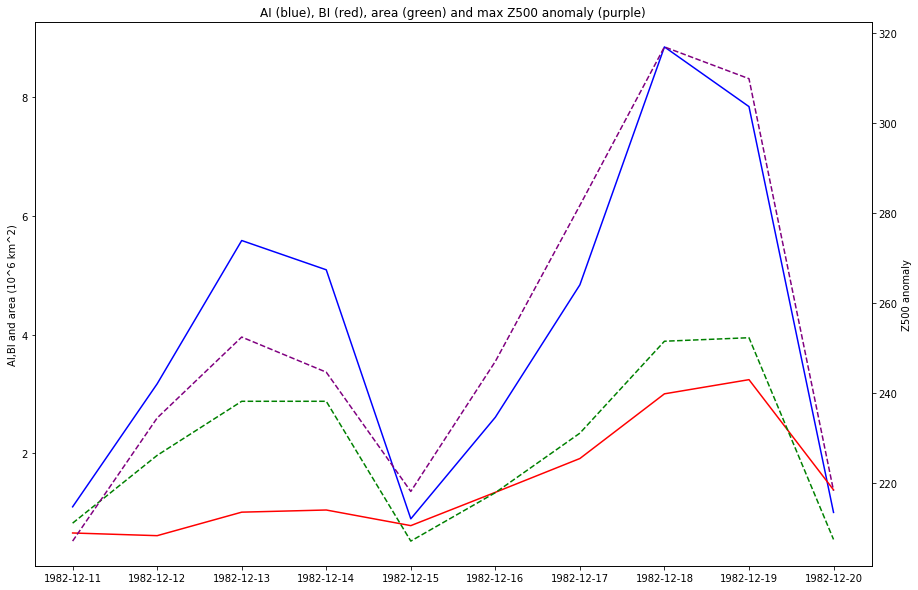

In [508]:
fig,ax1 = plt.subplots(figsize=(15,10))
ax1.set_title("AI (blue), BI (red), area (green) and max Z500 anomaly (purple)")
ax1.set_ylabel("AI,BI and area (10^6 km^2)")
ax1.plot(time_plt,dplot['AI'],color="blue")
ax1.plot(time_plt,dplot['BI'],color="red")
ax1.plot(time_plt,dplot['sum_area']/1000000,color="green",linestyle='dashed')

ax2 = ax1.twinx()
ax2.set_ylabel("Z500 anomaly")
ax2.plot(time_plt,dplot['amax'],color = 'purple',linestyle='dashed')

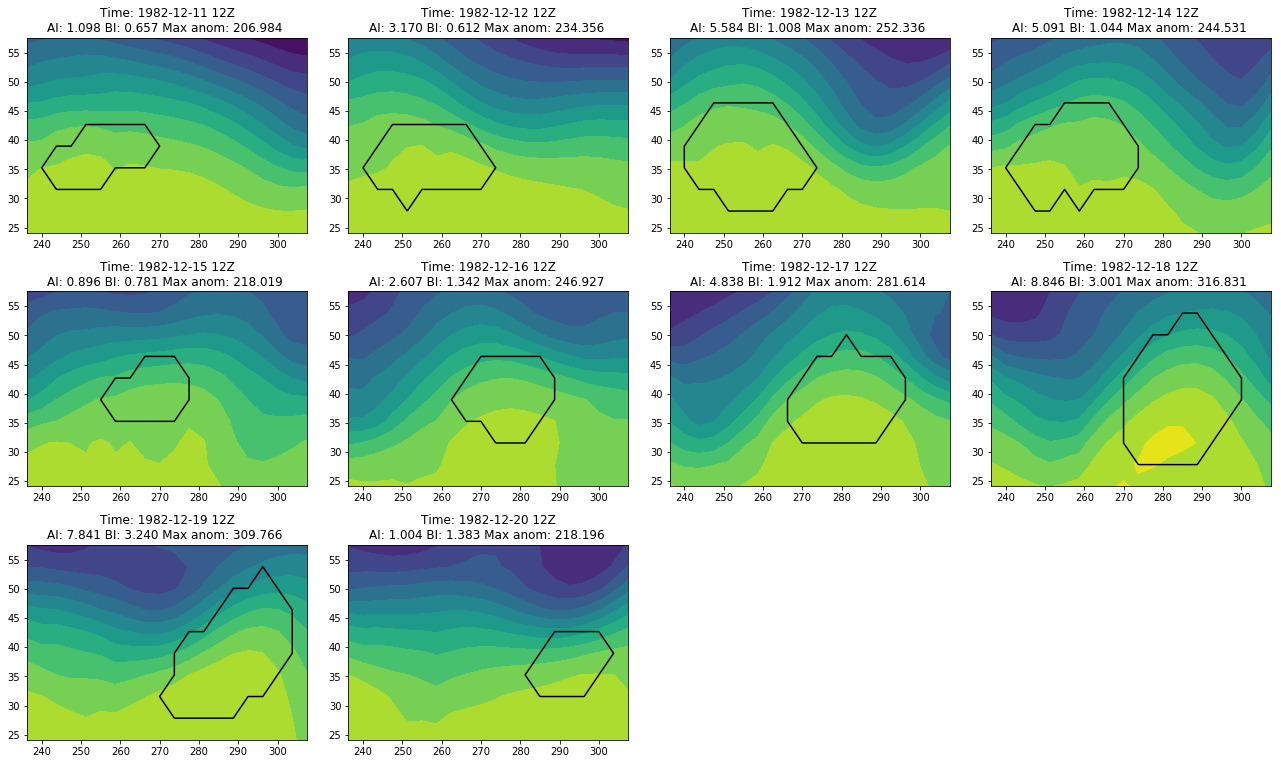

In [504]:
fig2 = plt.figure(figsize=(18,14))
i=1
levs=np.arange(4800,6100,100)
for t in dplot['time']:
    r = dplot.iloc[i-1]
    currt = t[:10]
    ps = plotslice.sel(time=currt)
    bs=blobslice.sel(time=currt)
    ax=fig2.add_subplot(4,4,i)
    ax.contourf(ps.lon.values,ps.lat.values,ps.values[0,:,:],levels=levs)
    #ax.contour(ps.lon.values,ps.lat.values,ps.values[0,:,:])
    ax.contour(bs.lon.values,bs.lat.values,bs.values[0,:,:],levels=[1],colors='k')
    ax.set_title("Time: {:} 12Z\nAI: {:.3f} BI: {:.3f} Max anom: {:.3f} ".format(currt,r['AI'],r['BI'],r['amax']))
    i+=1
plt.tight_layout()